# Quick tour of OpenVisus in python

### To begin using OpenVisus install it

```
python -m pip install --no-cache-dir --upgrade --force-reinstall OpenVisus
python -m OpenVisus configure 
```


### Define some utility functions:

In [1]:
from PIL import Image
from urllib.request import urlopen
import matplotlib.pyplot as plt

def LoadImage(filename):
	if filename.startswith("http"):
		filename=urlopen(filename) 
	return numpy.asarray(Image.open(filename))

def ShowImage(data,width=10):
	ratio=float(data.shape[1])/data.shape[0]
	fig = plt.figure(figsize = (width,width*ratio))
	ax = fig.add_subplot(1,1,1)
	ax.imshow(data, origin='lower')
	plt.show()

### First import OpenVisus

In [2]:
import sys
sys.path.append("./build/RelWithDebInfo")
from OpenVisus import *

PythonEngine is working fine


### Create an empty RGB dataset

In [3]:
CreateIdx(url="tmp/empty3d.idx",dim=3, dims=[1025,512,256],fields=[Field("data","uint8[3]","row_major")])

### Create a 2d dataset from numpy array

In [4]:
data=LoadImage('datasets/cat/rgb.png')
CreateIdx(url="tmp/visus2d.idx", dim=2,data=data)

### Create a 3d dataset from numpy array

In [5]:
data=numpy.zeros((100,100,100,3),dtype=numpy.float32) 
CreateIdx(url="tmp/visus3d.idx", dim=3, data=data)

### Create a 3d datasets from 2d slices

In [6]:
data=LoadImage('https://raw.githubusercontent.com/sci-visus/OpenVisus/master/datasets/cat/rgb.png')
height,width=data.shape[0],data.shape[1]

# replicate one 2d images 10 times
depth=10

def generateSlices():
    for I in range(depth): 
        yield data

db=CreateIdx(url="tmp/visus3d_slices.idx",dims=[width,height,depth],fields=[Field("data","uint8[3]","row_major")])
db.writeSlabs(generateSlices())

### Read a single slice

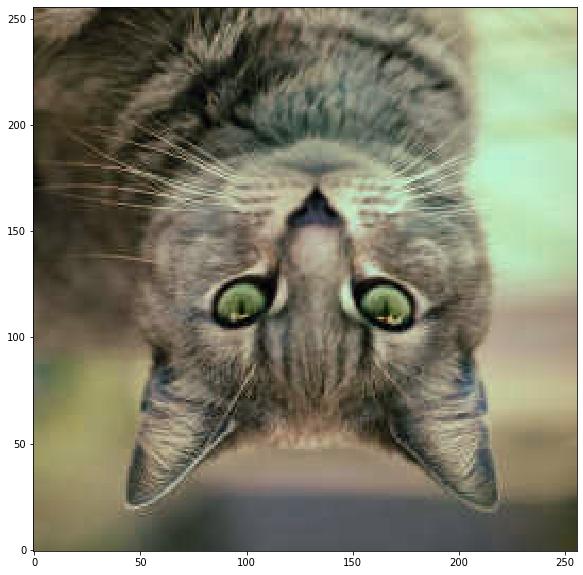

In [7]:
data=next(db.read(z=[0,1]))[0,:,:]
ShowImage(data)

### Read stuff in one shot at full resolution

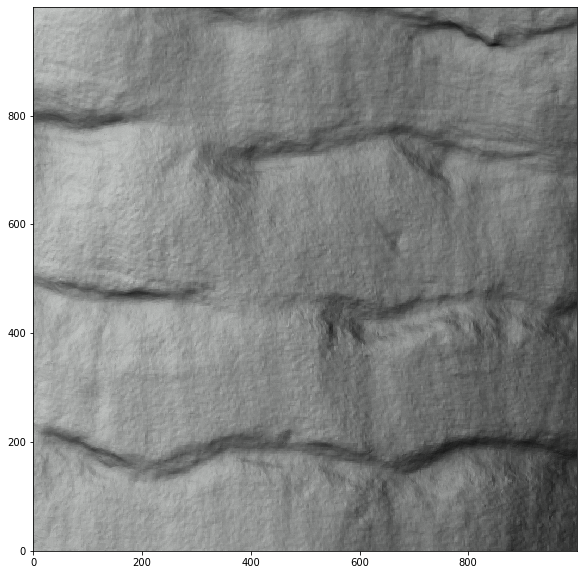

In [8]:
db=PyDataset("http://atlantis.sci.utah.edu/mod_visus?dataset=david_subsampled")
data=next(db.read(x=[10000,11000],y=[10000,11000]))
ShowImage(data)

### Show image coarse to fine

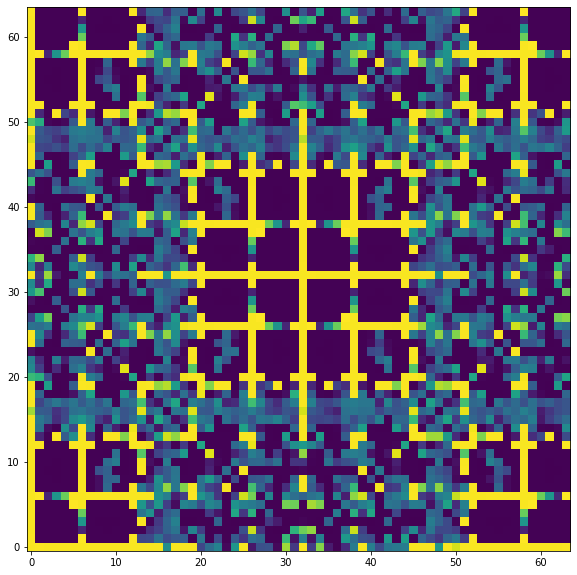

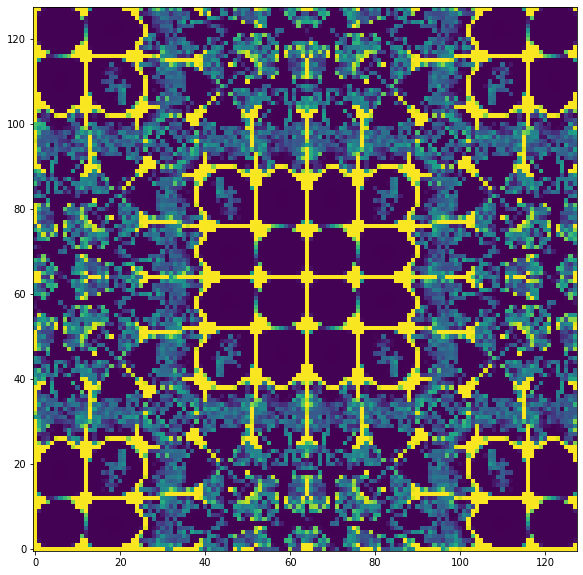

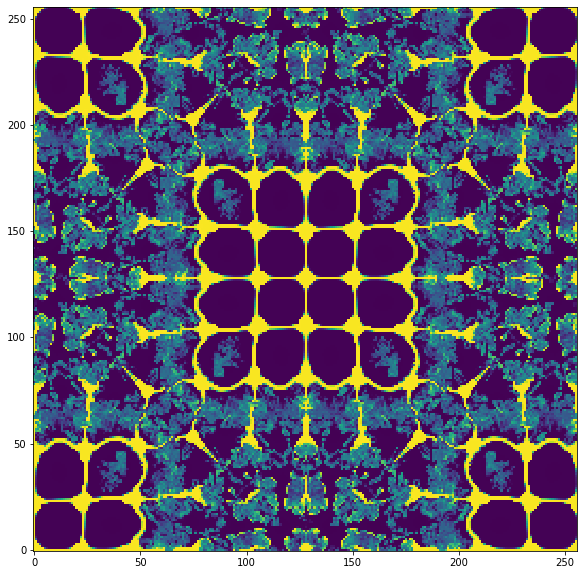

In [9]:
db=PyDataset("http://atlantis.sci.utah.edu/mod_visus?dataset=2kbit1")
for data in db.read(x=[0,2048],y=[0,2048],z=[1024,1025], num_refinements=3, quality=-9):
    ShowImage(data[0,:,:])

### Get data in normalized coordinates

(440, 183, 3) uint8


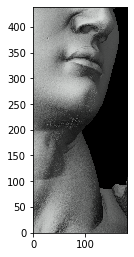

In [10]:
db=PyDataset("http://atlantis.sci.utah.edu/mod_visus?dataset=david_subsampled")
data=next(db.read(x=[0.35,0.45],y=[0.8,0.9],quality=-8))
print(data.shape,data.dtype)
ShowImage(data)

### Start a local visus server for one dataset

In [11]:
modvisus = ModVisus()

port=10000
idx="./datasets/cat/rgb.idx"
config="""
<visus>
  <datasets>
    <dataset name='default' url='{}' permissions='public' />
  </datasets>
</visus>
""".format(idx)
modvisus.configureDatasets(ConfigFile.fromString(config))
server=NetServer(port, modvisus)

server.runInBackground()

body=urlopen('http://127.0.0.1:{}/mod_visus?action=read_dataset&dataset=default'.format(port)).read().decode("utf8")
print(body)

server.signalExit()
server.waitForExit()
print("server done")

(version)
6
(box)
0 255 0 255
(fields)
data uint8[3] format(0) default_value(0) min(0 0 0) max(0 0 0) 
(bits)
V0101010101010101
(bitsperblock)
16
(blocksperfile)
1
(interleave block)
0
(filename_template)
./rgb/%01x.bin

server done


### Example of tiling images with several timesteps:

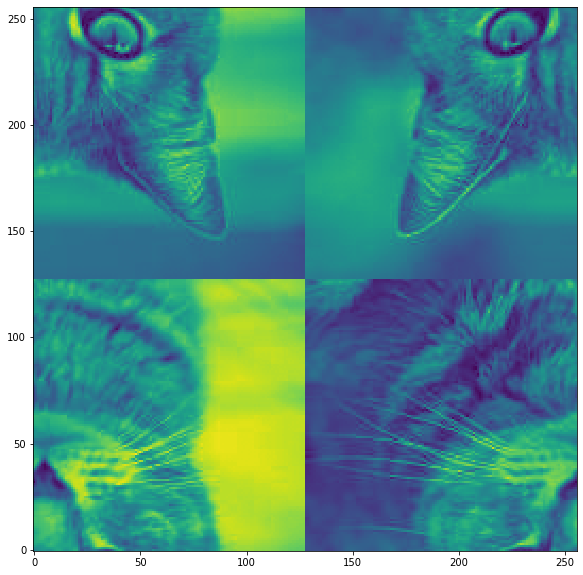

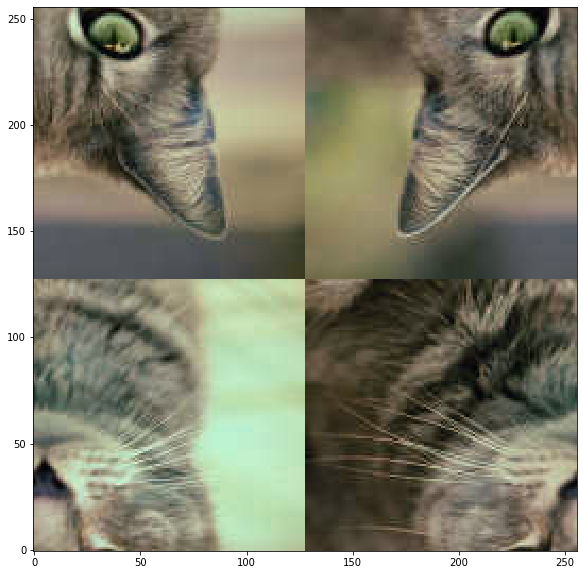

In [12]:
gray=CreateIdx(url="tmp/tiles/gray.idx",dim=2,data=LoadImage('https://raw.githubusercontent.com/sci-visus/OpenVisus/master/datasets/cat/gray.png'))
rgb =CreateIdx(url="tmp/tiles/rgb.idx" ,dim=2,data=LoadImage('https://raw.githubusercontent.com/sci-visus/OpenVisus/master/datasets/cat/rgb.png'))

dst=CreateIdx(url="tmp/tiles/test.idx",dims=[512,512],fields=[
	Field.fromString("gray uint8    default_compression(lz4)"),
	Field.fromString("rgb  uint8[3] default_compression(lz4)")],
	time=[0,4,"time%02d/"])
	
# example of tiling the same image multiple times
data=next(gray.read())
dst.write(data,x=  0,y=  0,field='gray',time=2)
dst.write(data,x=256,y=  0,field='gray',time=2)
dst.write(data,x=256,y=256,field='gray',time=2)
dst.write(data,x=  0,y=256,field='gray',time=2)
ShowImage(next(dst.read(x=[128,384],y=[128,384],field="gray",time=2)))

data=next(rgb.read())
dst.write(data,x=  0,y=  0,field='rgb',time=3)
dst.write(data,x=256,y=  0,field='rgb',time=3)
dst.write(data,x=256,y=256,field='rgb',time=3)
dst.write(data,x=  0,y=256,field='rgb',time=3)
ShowImage(next(dst.read(x=(128,128+256),y=(128,128+256),field="rgb" ,time=3)))